In [54]:
%load_ext tensorboard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import os, cv2, json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB4
from keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
WORK_DIR = 'C:\\Users\\shanm\\Downloads\\cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'test_images',
 'test_tfrecords',
 'train.csv',
 'train_images',
 'train_tfrecords']

In [56]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [57]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [58]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

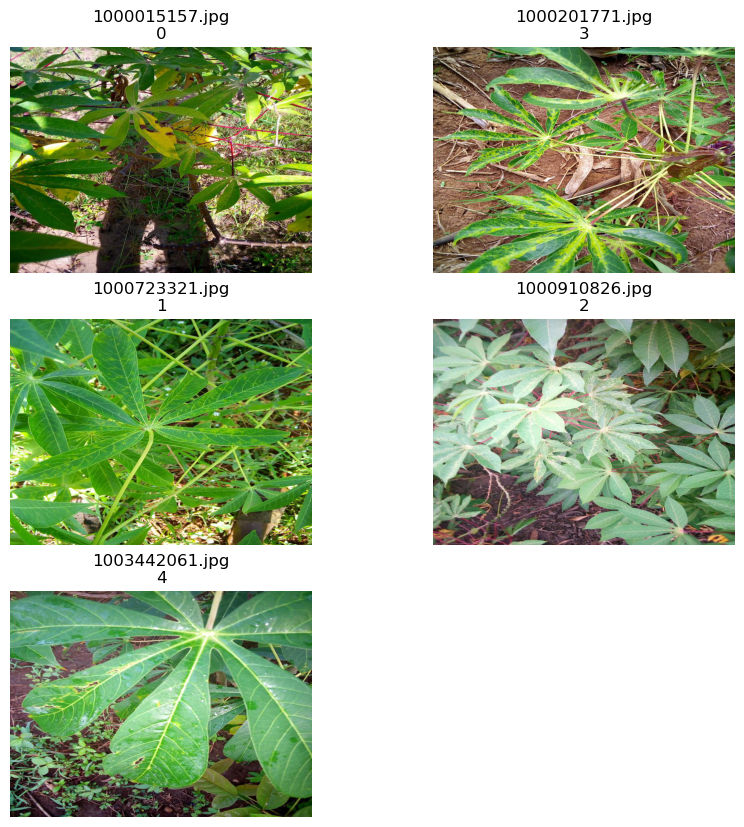

In [59]:
sample_images = ['1000015157.jpg','1000723321.jpg','1000910826.jpg','1000201771.jpg','1003442061.jpg']
sample_images_df = train_labels[train_labels.image_id.isin(sample_images)]
plt.figure(figsize=(10,10))
for ind, (image_id, label) in enumerate(zip(sample_images_df.image_id, sample_images_df.label)):
    plt.subplot(3, 2, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title('{}\n{}'.format(image_id,label))
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

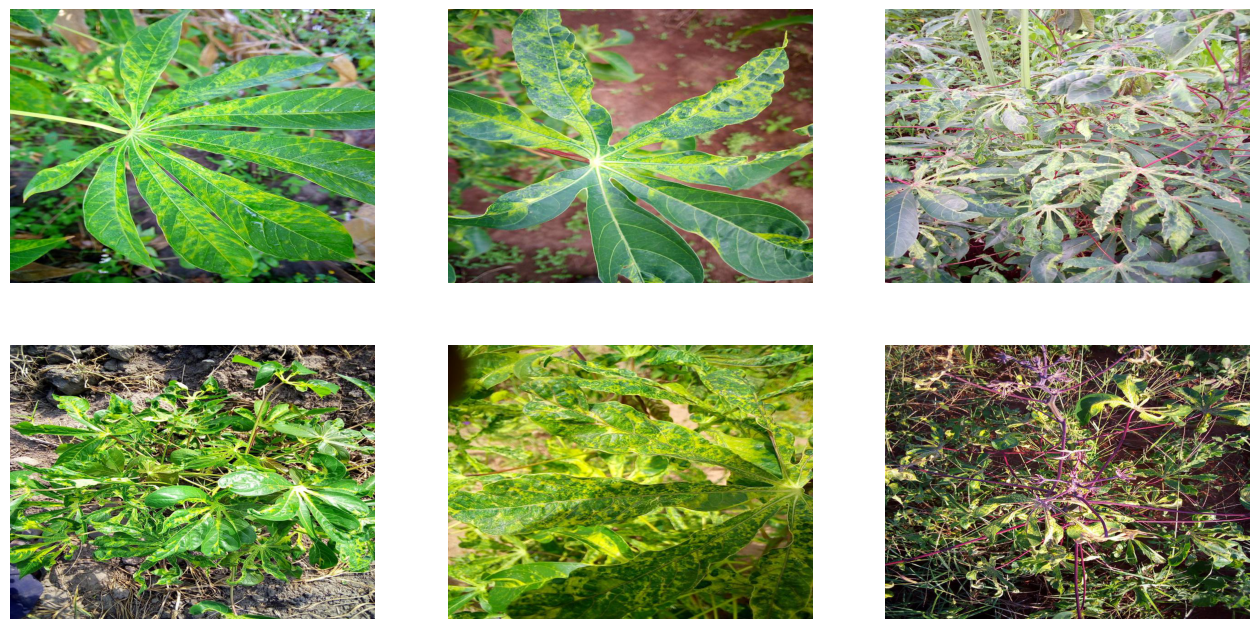

In [60]:
sample = train_labels[train_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

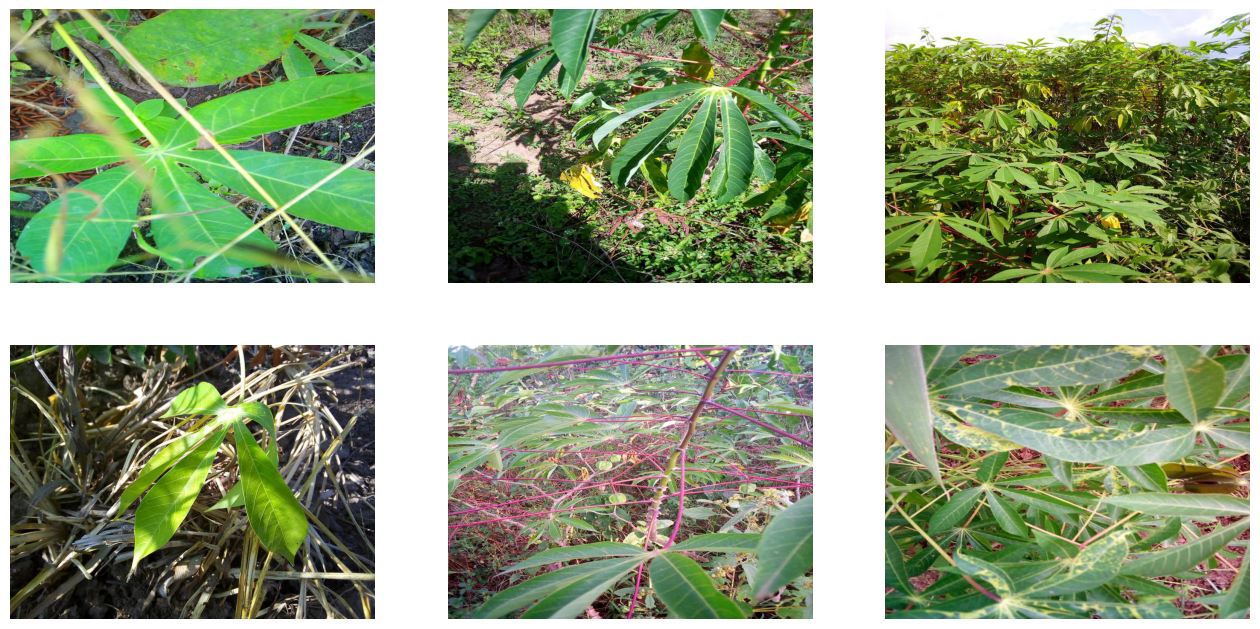

In [61]:
sample = train_labels[train_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

In [62]:
y_pred = [3] * len(train_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, train_labels.label,normalize=True))

The baseline accuracy: 0.615


In [63]:
BATCH_SIZE = 25
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 10
TARGET_SIZE = 209

In [64]:
train_labels.label = train_labels.label.astype('str')
#validation_split parameter allows for us to split 20% of the data into the validation set automatically without train test split
#Then you can allow .flow_from_dataframe to breakout the train versus validation in the data
train_generator = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     rotation_range = 5,
                                     fill_mode = 'constant',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [65]:
def create_model():
    model = models.Sequential()

    model.add(EfficientNetB4(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [66]:
model = create_model()

In [67]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1792)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 8965      
Total params: 17,682,788
Trainable params: 17,557,581
Non-trainable params: 125,207
_________________________________________________________________


In [68]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
model_save = ModelCheckpoint('best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [69]:

history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [tensorboard_callback,model_save, early_stop, reduce_lr]
    )

Epoch 1/10
684/684 [==============================] - 12907s 19s/step - loss: 0.7116 - acc: 0.7478 - val_loss: 0.5693 - val_acc: 0.7983

Epoch 00001: val_loss improved from inf to 0.56927, saving model to best_baseline_model.h5
Epoch 2/10
684/684 [==============================] - 11271s 16s/step - loss: 0.5530 - acc: 0.8059 - val_loss: 0.5822 - val_acc: 0.7993

Epoch 00002: val_loss did not improve from 0.56927
Epoch 3/10
684/684 [==============================] - 9287s 14s/step - loss: 0.5039 - acc: 0.8254 - val_loss: 0.5237 - val_acc: 0.8294

Epoch 00003: val_loss improved from 0.56927 to 0.52370, saving model to best_baseline_model.h5
Epoch 4/10
684/684 [==============================] - 10845s 16s/step - loss: 0.4733 - acc: 0.8368 - val_loss: 0.5538 - val_acc: 0.8100

Epoch 00004: val_loss did not improve from 0.52370
Epoch 5/10
684/684 [==============================] - 9717s 14s/step - loss: 0.4525 - acc: 0.8443 - val_loss: 0.6092 - val_acc: 0.7785

Epoch 00005: val_loss did not

In [70]:
model.save('Final_model.h5')

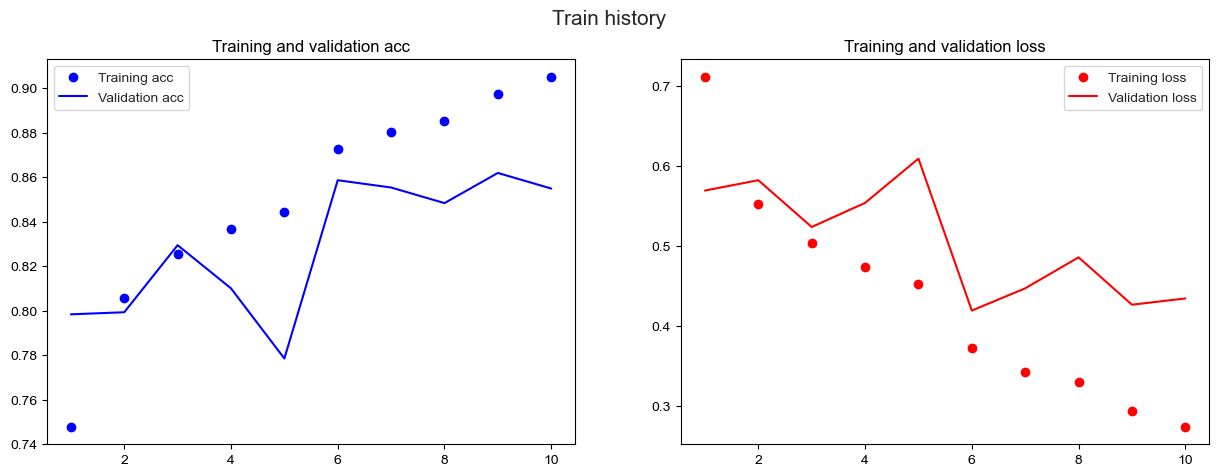

In [73]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, accuracy, "bo", label = "Training acc")
ax1.plot(epochs, val_accuracy, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [75]:
print('Test images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "test_images"))))

Test images: 1


In [89]:
preds = []


image = Image.open(os.path.join(WORK_DIR,  "test_images",'cgmv2.jpg'))
image = image.resize((TARGET_SIZE, TARGET_SIZE))
image = np.expand_dims(image, axis = 0)
preds.append(np.argmax(model.predict(image)))

preds

[2]

In [91]:
%tensorboard --logdir logs/fit